In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.shape

(21613, 21)

In [5]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

#### Meanings

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartment interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high-quality level of construction and design
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Latitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


## EDA

- Eliminar las columnas de id y date ya que para la implementación de esta red neuronal, no tendrán gran relevancia

In [6]:
df.drop(columns=['id', 'date'], inplace=True)

In [7]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [8]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
print(df.dtypes)

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.pairplot(data=df)
# plt.show()

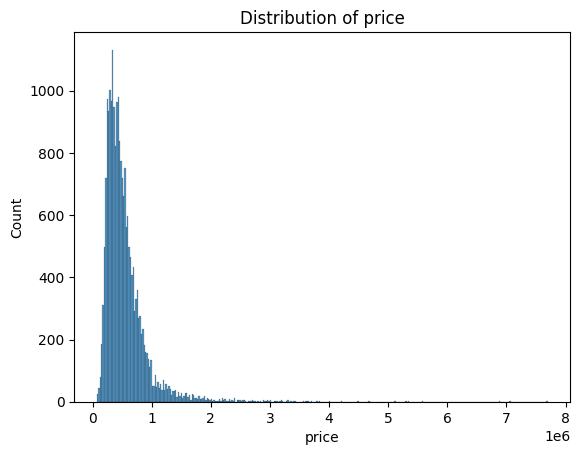

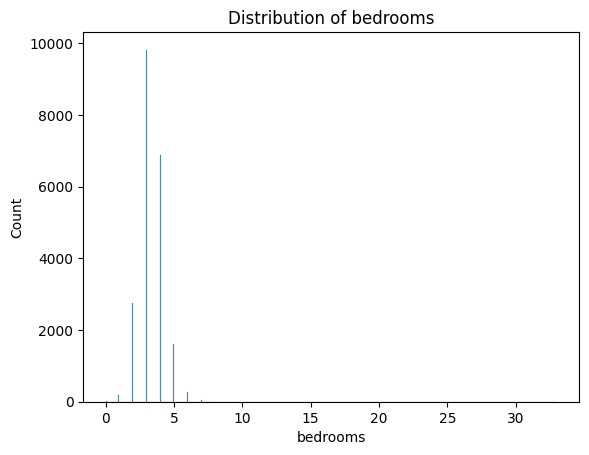

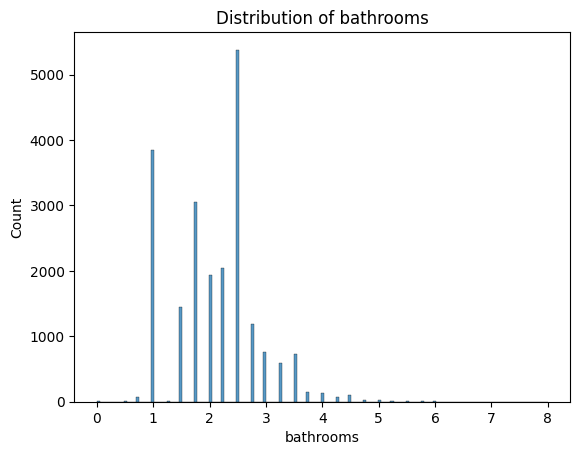

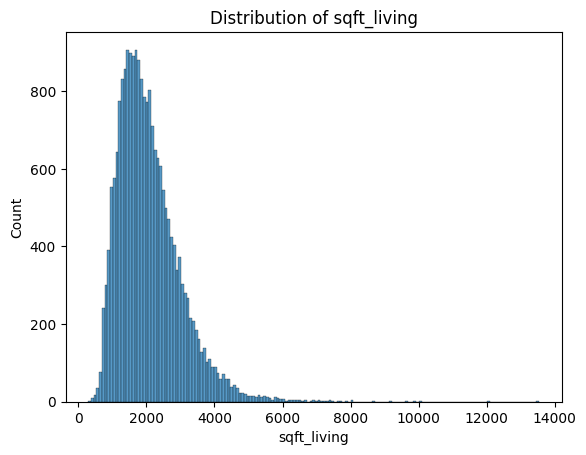

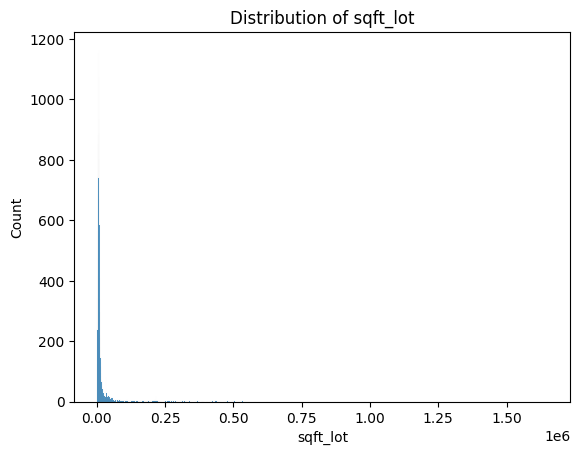

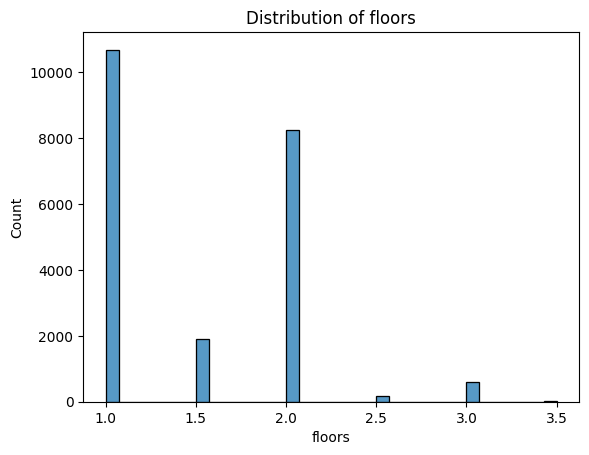

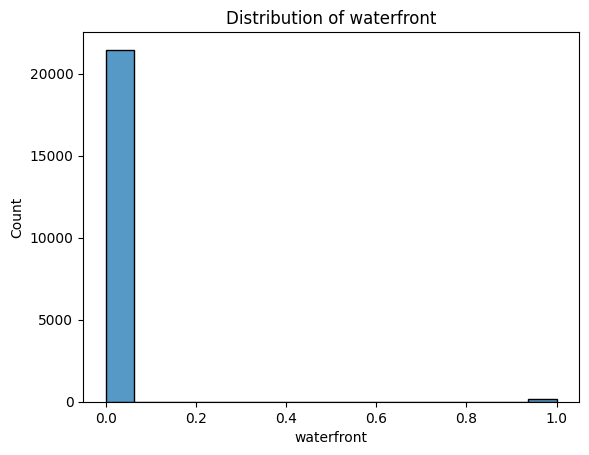

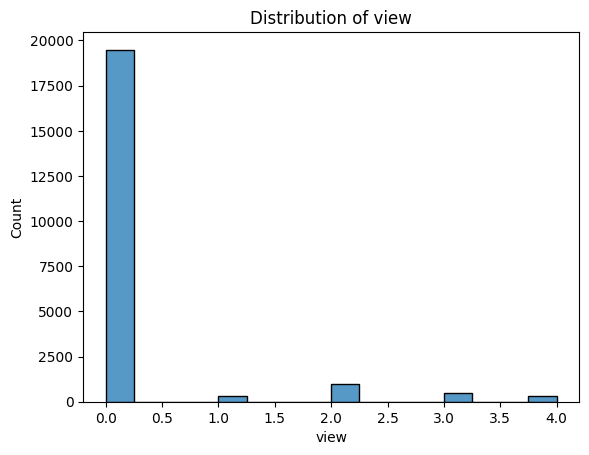

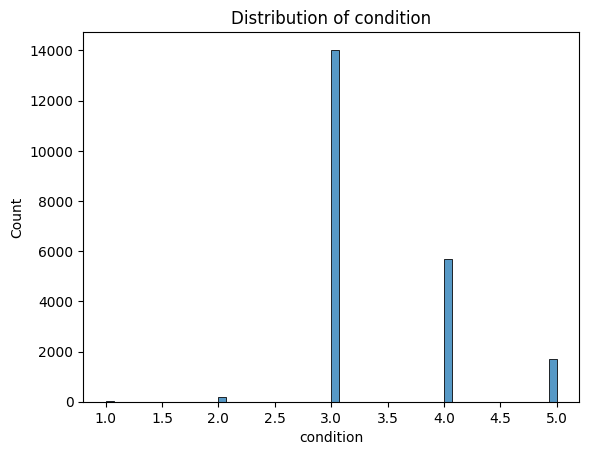

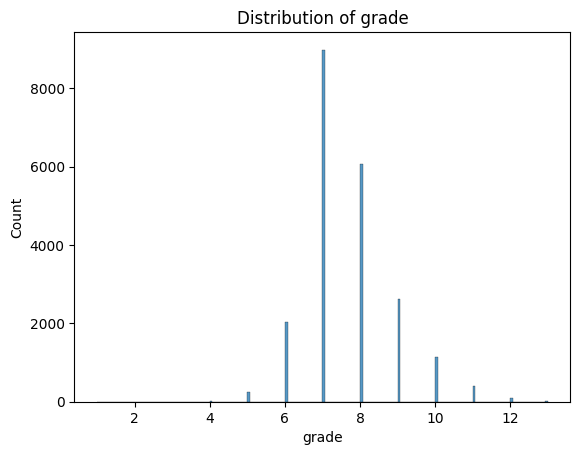

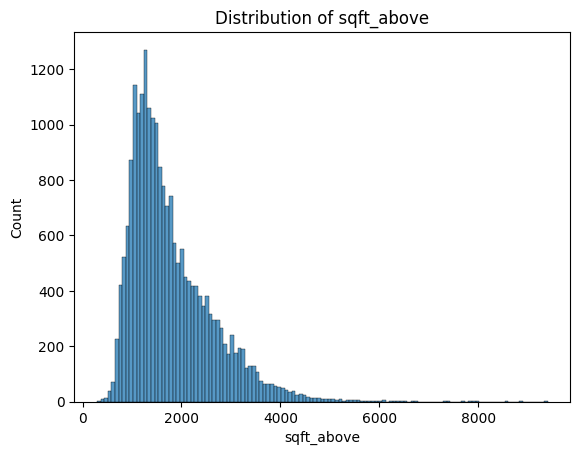

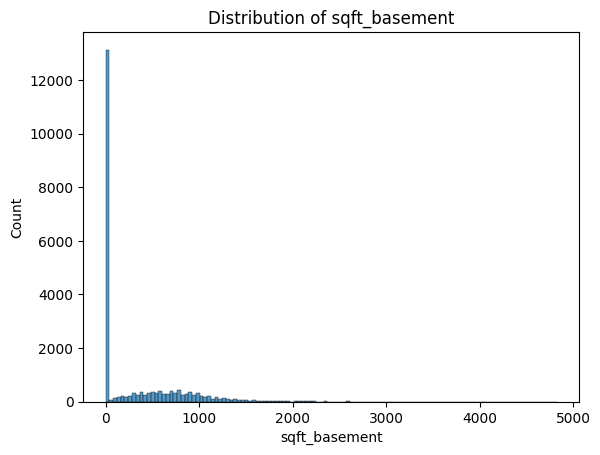

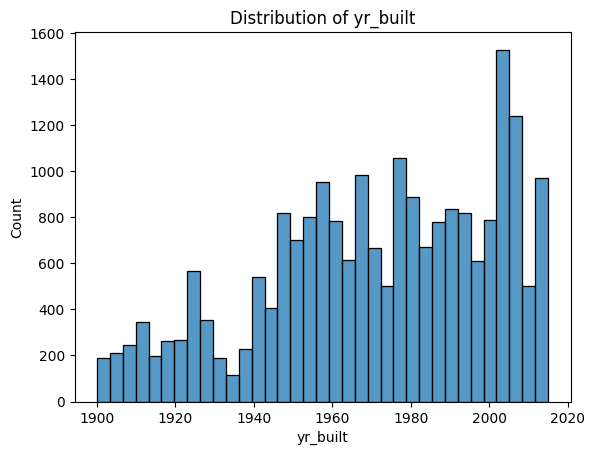

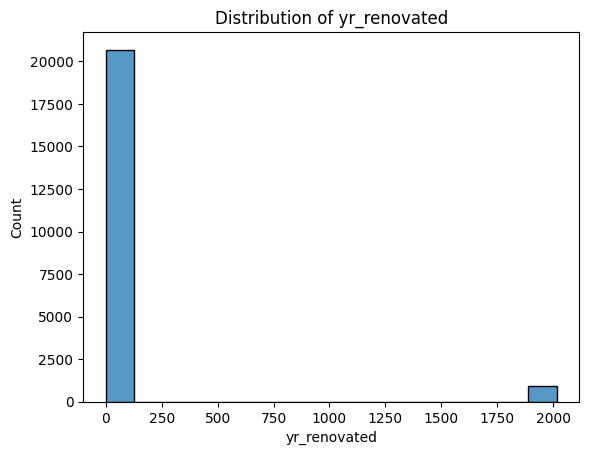

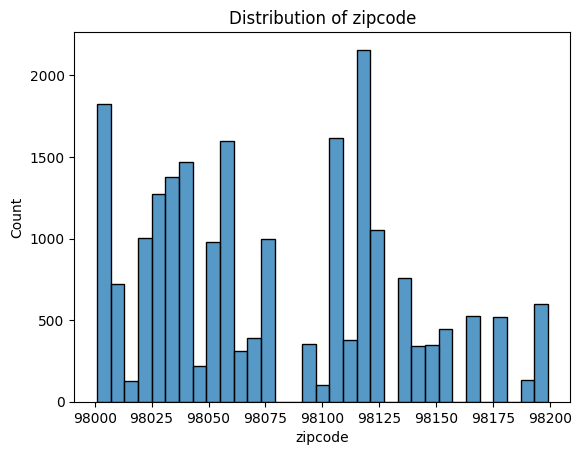

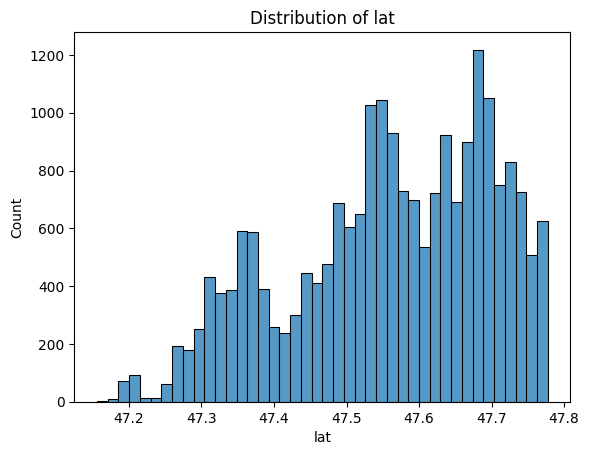

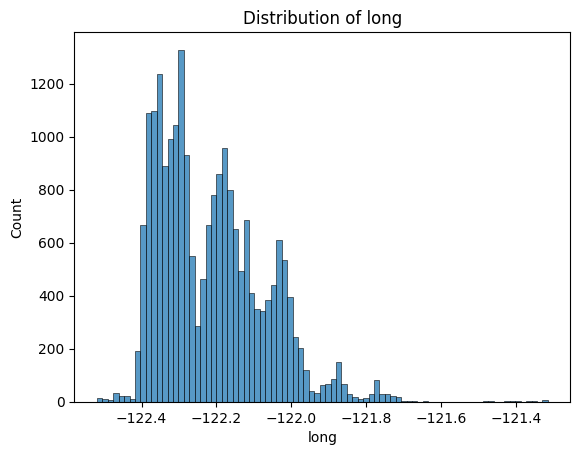

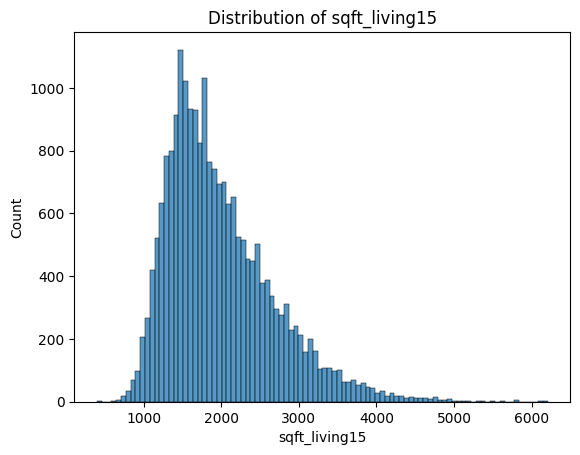

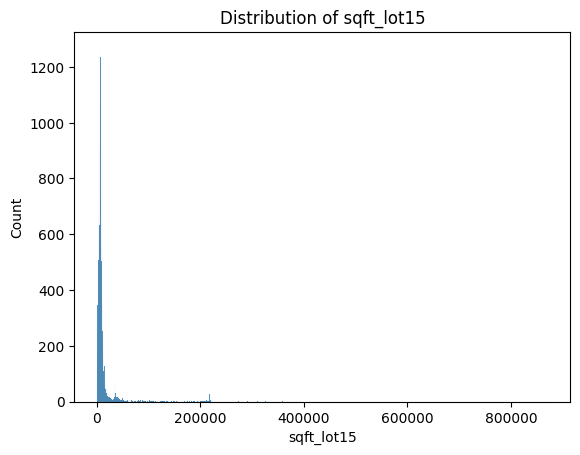

In [11]:
def plot_hist(df, columns):
    for column in columns:
        sns.histplot(data=df, x=column)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()

to_plot = [column for column in df.columns if df[column].dtype in ['int64', 'float64']]

plot_hist(df, to_plot)


#### Preprocess

* Identificar la cantidad de outliers en la dimensión objetivo [x]
* Estandarizar

In [12]:
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

# IQR method to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'The lower and upper bounds for price dimension are: {lower_bound}, {upper_bound}')

The lower and upper bounds for price dimension are: -162625.0, 1129575.0


In [13]:
# Log scale
df.loc[:, 'price'] = np.log1p(df['price'])

# Filtering outliers from the price dimension
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [14]:
import numpy as np
# MinMax Scaler since we have the same unit in the prices and we do not follow an specific distribution
from sklearn.preprocessing import MinMaxScaler

scaler_price = MinMaxScaler()

prices = np.array(df['price']).reshape(-1, 1)

normalized_prices = scaler_price.fit_transform(prices)

df.loc[:, 'price'] = normalized_prices

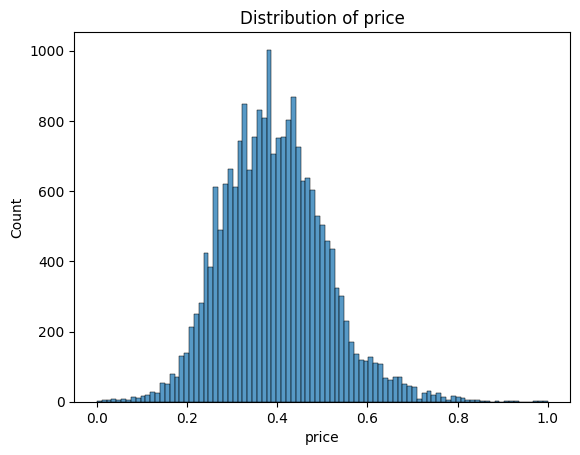

In [15]:
plot_hist(df, ['price'])

#### Preprocess first inputs (sqft_living, sqft_lot)

In [16]:
def get_bounds(df, columns):
    for column in columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f'The lower and upper bounds for {column} dimension are: {lower_bound}, {upper_bound}')

get_bounds(df, ['sqft_living', 'sqft_lot', 'floors', 'bathrooms', 'bedrooms', 'grade', 'condition'])

The lower and upper bounds for sqft_living dimension are: -257.5, 4234.5
The lower and upper bounds for sqft_lot dimension are: -3432.0, 19160.0
The lower and upper bounds for floors dimension are: -0.5, 3.5
The lower and upper bounds for bathrooms dimension are: 0.625, 3.625
The lower and upper bounds for bedrooms dimension are: 1.5, 5.5
The lower and upper bounds for grade dimension are: 5.5, 9.5
The lower and upper bounds for condition dimension are: 1.5, 5.5


In [17]:
df.loc[:, 'sqft_living'] = np.log1p(df['sqft_living'])
df.loc[:, 'sqft_lot'] = np.log1p(df['sqft_lot'])
df.loc[:, 'floors'] = np.log1p(df['floors'])
df.loc[:, 'condition'] = np.log1p(df['condition'])
df.loc[:, 'grade'] = np.log1p(df['grade'])
df.loc[:, 'bathrooms'] = np.log1p(df['bathrooms'])
df.loc[:, 'bedrooms'] = np.log1p(df['bedrooms'])

/tmp/ipykernel_3796/3547961378.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.07411682 7.85205021 6.64768837 ... 6.92853782 7.37838371 6.92853782]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'sqft_living'] = np.log1p(df['sqft_living'])
/tmp/ipykernel_3796/3547961378.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.6395878  8.88779076 9.21044037 ... 7.20860034 7.77863015 6.98193468]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'sqft_lot'] = np.log1p(df['sqft_lot'])
/tmp/ipykernel_3796/3547961378.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.38629436 1.38629436 1.38629436 ... 1.38629436 1.38629436 1.38629436]' has dtype incompatible with int64,

In [18]:
scaler_features = MinMaxScaler()
features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'condition', 'grade', 'view']
df[features] = scaler_features.fit_transform(df[features])

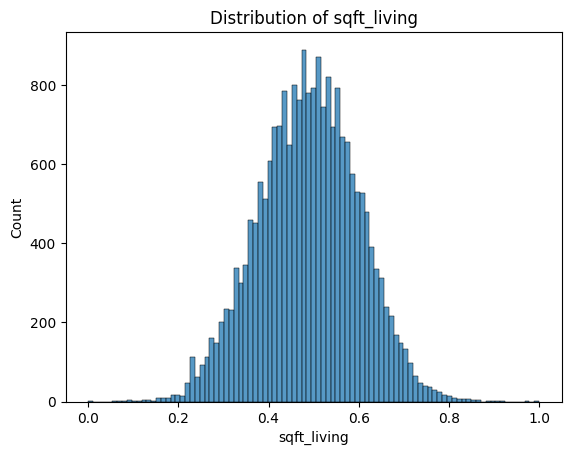

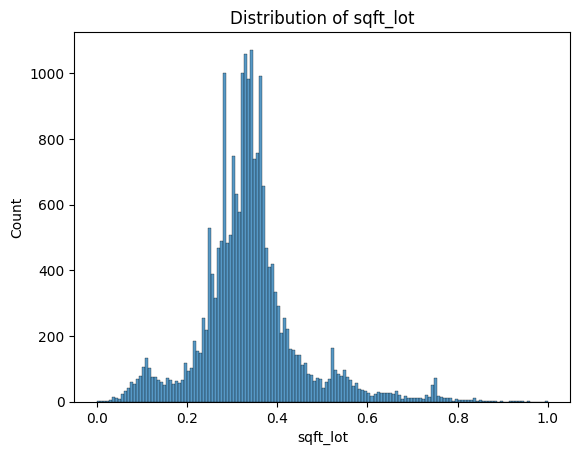

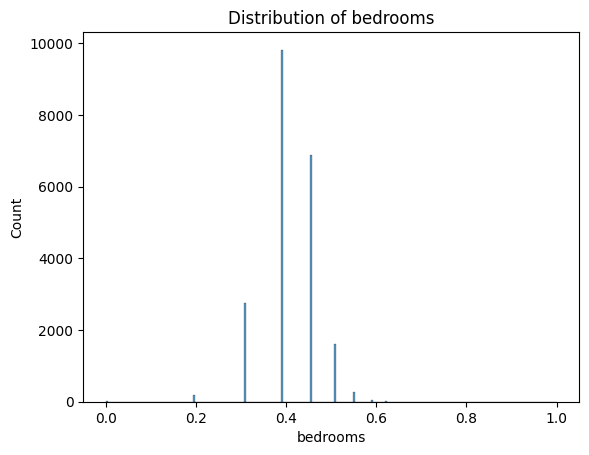

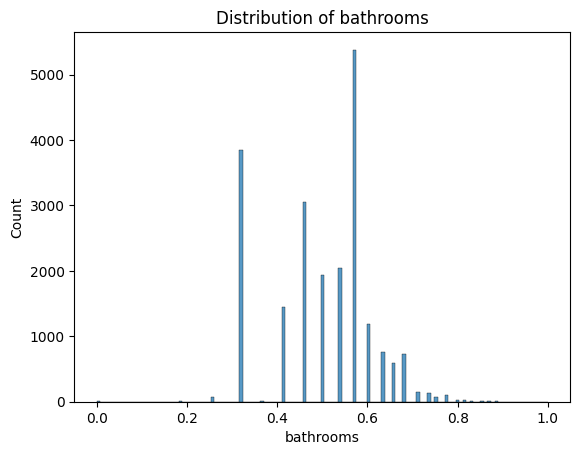

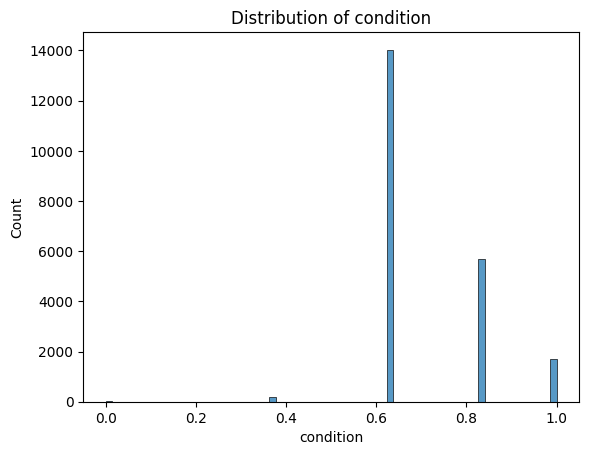

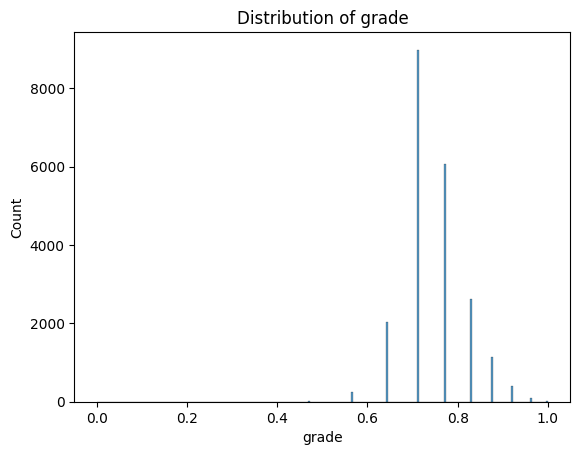

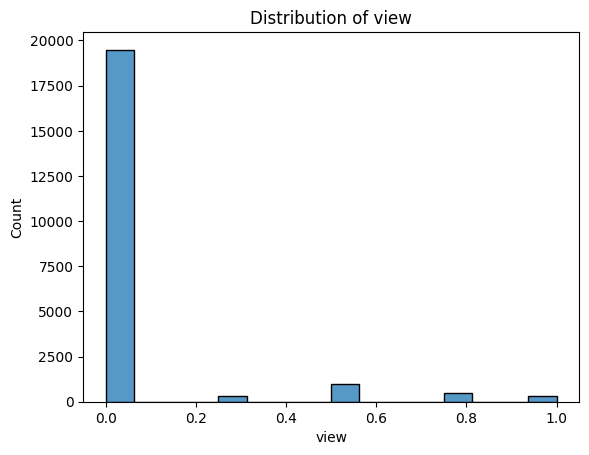

In [19]:
plot_hist(df, features)

## ANN

In [20]:
X = df[features]
y = df['price']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))


model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


loss, mae = model.evaluate(X_test, y_test)

print(f'Loss: {loss}, Mean Absolute Error: {mae}')


2024-06-25 16:41:43.764144: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 16:41:43.769276: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 16:41:43.956788: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 16:41:44.693691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 16:41:46.714941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Epoch 1/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0306 - mae: 0.1285 - val_loss: 0.0159 - val_mae: 0.1014
Epoch 2/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0092 - mae: 0.0759 - val_loss: 0.0099 - val_mae: 0.0797
Epoch 3/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0079 - mae: 0.0708 - val_loss: 0.0066 - val_mae: 0.0654
Epoch 4/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0072 - mae: 0.0680 - val_loss: 0.0075 - val_mae: 0.0698
Epoch 5/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0068 - mae: 0.0662 - val_loss: 0.0060 - val_mae: 0.0625
Epoch 6/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0066 - mae: 0.0655 - val_loss: 0.0057 - val_mae: 0.0602
Epoch 7/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - mae: 0.0645 - val_loss: 0.0056 - val_mae: 0.0601
Epoch 8/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - mae: 0.0634 - val_loss: 0.0058 - val_mae: 0.0608
Epoch 9/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0666
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


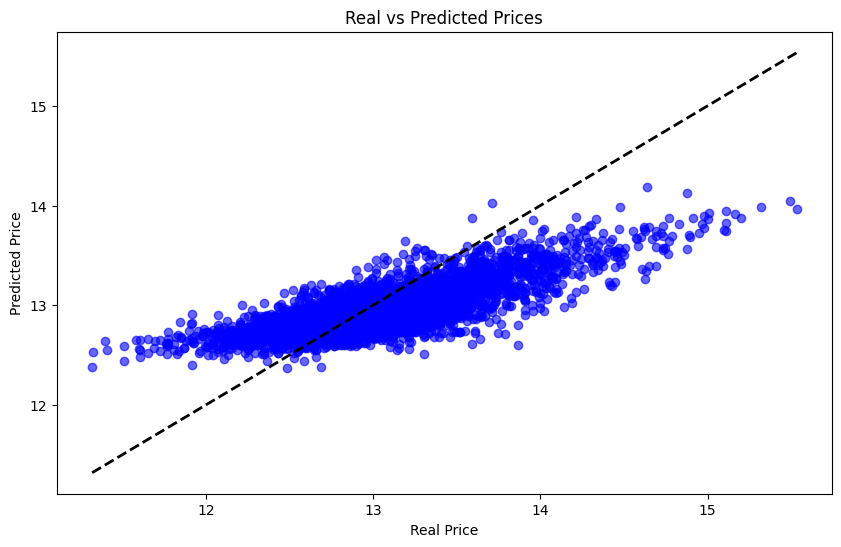

In [23]:
loss = model.evaluate(X_test, y_test)

norm_price_predictions = model.predict(X_test)

price_predictions = scaler_price.inverse_transform(norm_price_predictions).flatten()

actual_prices = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

comparison_df = pd.DataFrame({
    'Predicted Price': price_predictions,
    'Actual Price': actual_prices
})

plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, price_predictions, alpha=0.6, color='b')
plt.plot([actual_prices.min(), actual_prices.max()], [actual_prices.min(), actual_prices.max()], 'k--', lw=2)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Real vs Predicted Prices')
plt.show()


In [24]:
comparison_df

,Predicted Price,Actual Price
0,12.989542,12.807655
1,13.255650,13.670486
2,13.539737,13.852807
3,13.723373,14.214287
4,13.154125,13.474429
...,...,...
4318,12.728593,12.730804
4319,13.139944,13.419502
4320,13.004097,12.560248
4321,13.036635,13.312985
